In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import hopsworks
from dotenv import dotenv_values
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [15]:
# REPLACE .api_key WITH YOUR OWN KEY_VALUE
config = dotenv_values(".api_key")
hopsworks_key = config["HOPSWORKS_KEY"]
#print(hopsworks_key)

In [16]:
# Log in To Hopsworks
project = hopsworks.login(api_key_value=hopsworks_key)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193692
Connected. Call `.close()` to terminate connection gracefully.


In [17]:
# Get Feature Group from Hopsworks

comments_fg = fs.get_feature_group(name="comments", version=1)
query = comments_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="comments",
                                  version=1,
                                  description="Read from Youtube Comments Dataset",
                                  labels=["sentiment"],
                                  query=query)

In [19]:
# Get our feature view data and then label them, this way we automate the process
df=feature_view.get_batch_data()
#print(df)

commies = df['comment']
print(type(commies))

analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
#print(df)

Finished: Reading data from Hopsworks, using ArrowFlight (3.51s) 
<class 'pandas.core.series.Series'>


In [20]:
# Training our Model from Feature View 

# Get the Feature View df

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = feature_view.train_test_split(test_size=0.2)


print(train_labels)
print(test_data)

Finished: Reading data from Hopsworks, using ArrowFlight (3.82s) 
       sentiment
0         0.8020
1        -0.5423
2         0.4019
3         0.7096
4        -0.8020
...          ...
56895     0.0000
56896     0.7506
56897    -0.6428
56898    -0.5574
56899    -0.3400

[45520 rows x 1 columns]
                                                 comment
9      Thanks to all the smurfers all the banned play...
15     RhandlerR thank you for the update  I know it ...
17     A massive lawsuit against Johnson  Johnson wil...
21                    Check out my Facebook to follow my
23     I have enjoyed the       Black Ops Cold WarIS ...
...                                                  ...
56867  FUCK YOUR SHIT GAME GTA I SPENT 200k ON A CAR ...
56868  How the fuck could you not like Red Dead Redee...
56871                             Just bought GTA Im lit
56877  many more MinecraftRTX Screenshots The time of...
56889  Instead of being sad that we had to guide Arth...

[11380 rows x 1 col

In [21]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['comment'], df['sentiment'], test_size=0.2, random_state=42)

# Convert comments to TF-IDF features
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_features, train_labels)

# Predict on the test set
predictions = model.predict(test_features)

# Evaluate the model
mse = mean_squared_error(test_labels, predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.052571699269953365
Root Mean Squared Error: 0.2292851919988584


## For LinearRegression:
- Mean Squared Error: 0.1323086672735092
- Root Mean Squared Error: 0.363742583805511

## For RandomForestRegression
- Mean Squared Error: 0.048405059045893824
- Root Mean Squared Error: 0.22001149753113772

In [22]:
# testing a single message

message = ["i hate gamers"]

test_stuff = vectorizer.transform(message)

output = model.predict(test_stuff)
print("-------------------------------------------")
print(output)

-------------------------------------------
[-0.5719]


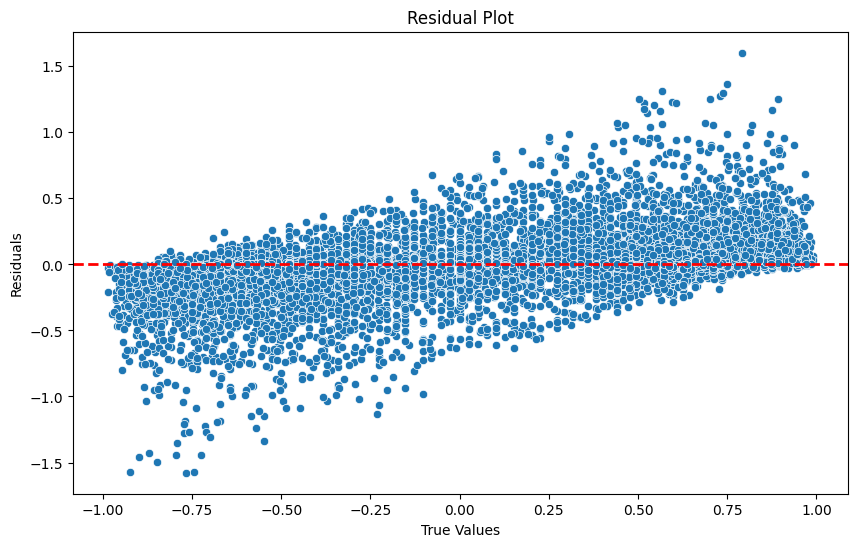

In [23]:
# Residual Plot
import matplotlib.pyplot as plt
import seaborn as sns

residuals = test_labels - predictions

# Create a residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_labels, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()



In [24]:
# Create model directory and pickle file for model and the vectorizer
import joblib
import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

mr = project.get_model_registry()

model_dir = "comments_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/comments_model.pkl")       #binary serialization of model in python

# Save vectorizer to 'model_dir'
joblib.dump(vectorizer, model_dir + "/vectorizer.pkl")

Connected. Call `.close()` to terminate connection gracefully.


['comments_model/vectorizer.pkl']

In [25]:
# Upload the model directory to Hopsworks
input_schema = Schema(train_data)
output_schema = Schema(train_labels)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
comments_model = mr.python.create_model(
    name="comments_model", 
    model_schema=model_schema,
    description="Youtube Sentiment Analyzer"
)

# Upload the model to the model registry, including all files in 'model_dir'
comments_model.save(model_dir)


Uploading: 100.000%|██████████| 1014882/1014882 elapsed<00:02 remaining<00:002.94it/s]
Uploading: 100.000%|██████████| 233199185/233199185 elapsed<03:43 remaining<00:00it/s]
Uploading: 100.000%|██████████| 254/254 elapsed<00:09 remaining<00:00<08:52, 133.21s/it]
Model export complete: 100%|██████████| 6/6 [04:34<00:00, 45.69s/it]                    

Model created, explore it at https://c.app.hopsworks.ai:443/p/193692/models/comments_model/2


Model(name: 'comments_model', version: 2)